In [35]:
import numpy as np
import torch


class ODBTC():
    def __init__(self, size):
        self.size = size
        self.ditherMatrix = self.bayer(size)
        max = np.max(self.ditherMatrix)
        min = np.min(self.ditherMatrix)
        self.ditherMatrix = (self.ditherMatrix - min) / (max - min)

    def rgb2grayscale(self, image):
        temp = image[0, :, :] * 0.2989 + image[1, :, :] * 0.587 + image[2, :, :] * 0.114
        temp = temp.astype(np.uint8)
        return temp

    def bayer(self, normalize=True):
        matrix = self.create_bayer(0, 0, self.size, 0, 1)
        return matrix / (self.size * self.size) \
            if normalize else matrix

    def create_bayer(self, x, y, size, value, step, matrix=None):
        if matrix is None:
            matrix = np.zeros((size, size))
        if (size == 1):
            matrix[y][x] = value
            return

        half = size // 2
        self.create_bayer(x, y, half, value + (step * 0), step * 4, matrix)
        self.create_bayer(x + half, y + half, half, value + (step * 1), step * 4, matrix)
        self.create_bayer(x + half, y, half, value + (step * 2), step * 4, matrix)
        self.create_bayer(x, y + half, half, value + (step * 3), step * 4, matrix)
        return matrix

    def __call__(self, image):
        grayscaleImage = self.rgb2grayscale(image)
        for i in range(len(image)):
            image[i] = self.filter(image[i], i, grayscaleImage)

        return image

    def filter(self, image_channel, c, gs):
        x = image_channel.shape[0] / self.size
        y = image_channel.shape[1] / self.size
        block_image = np.split(np.concatenate(np.split(image_channel, y, axis=1)), x * y)

        block_image_gs = np.split(np.concatenate(np.split(gs, y, axis=1)), x * y)
        for i in range(len(block_image)):
            min = np.min(block_image[i])
            max = np.max(block_image[i])

            gsMin = np.min(block_image_gs[i])

            k = max - min

            temp = self.ditherMatrix.copy()

            d = (temp * k) + gsMin
            
            block_image[i][block_image[i] >= d] = max
            block_image[i][block_image[i] < d] = min

        block_image = np.concatenate(block_image)
        block_image = np.split(block_image, x)

        temp_last = np.concatenate(block_image, axis=1)
        
        return temp_last

ad = ODBTC(8)

In [36]:
dither = ad.ditherMatrix
print(dither)

[[0.         0.50793651 0.12698413 0.63492063 0.03174603 0.53968254
  0.15873016 0.66666667]
 [0.76190476 0.25396825 0.88888889 0.38095238 0.79365079 0.28571429
  0.92063492 0.41269841]
 [0.19047619 0.6984127  0.06349206 0.57142857 0.22222222 0.73015873
  0.0952381  0.6031746 ]
 [0.95238095 0.44444444 0.82539683 0.31746032 0.98412698 0.47619048
  0.85714286 0.34920635]
 [0.04761905 0.55555556 0.17460317 0.68253968 0.01587302 0.52380952
  0.14285714 0.65079365]
 [0.80952381 0.3015873  0.93650794 0.42857143 0.77777778 0.26984127
  0.9047619  0.3968254 ]
 [0.23809524 0.74603175 0.11111111 0.61904762 0.20634921 0.71428571
  0.07936508 0.58730159]
 [1.         0.49206349 0.87301587 0.36507937 0.96825397 0.46031746
  0.84126984 0.33333333]]


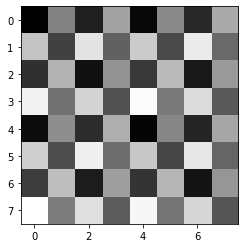

In [37]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.imshow(dither,cmap=plt.get_cmap('gray'))
plt.show()

(224, 224)


ValueError: num must be 1 <= num <= 64, not 65

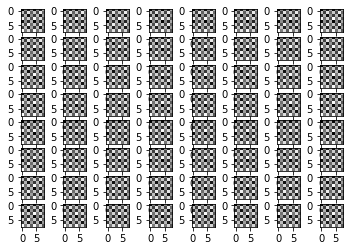

In [38]:
from PIL import Image
import numpy as np
img = Image.open('../dataset/train/grayscale/4.png')
arr_img = np.array(img)
print(arr_img.shape)
temp = ad.filter(arr_img,1,arr_img)
plt.imshow(arr_img,cmap=plt.get_cmap('gray'))

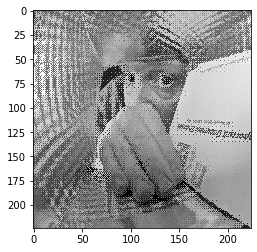

In [5]:
plt.imshow(temp,cmap=plt.get_cmap('gray'))